In [535]:
%load_ext autoreload
%autoreload 2

from util import *

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
import missingno as msno
from setify import datasets #Mina Gabriel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [536]:
df = datasets.data('titanic')
train_df = df[:891] 
test_df = df[891:]
print(f"Train Dataset: {len(train_df)}/{len(df)}")
print(f"Test Dataset: {len(test_df)}/{len(df)}")
df.head(3)

Train Dataset: 891/1309
Test Dataset: 418/1309


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282


**Embarked**: This attribute indicates the port where a passenger boarded the Titanic. There are three possible values:
- **C = Cherbourg**
- **Q = Queenstown**
- **S = Southampton**

**Parch**: Stands for "Parents/Children." It represents the number of parents or children each passenger had on board.

**Pclass**: This is a proxy for socio-economic status (SES) and is an integer value:
- **1 = 1st class (Upper)**
- **2 = 2nd class (Middle)**
- **3 = 3rd class (Lower)**

**SibSp**: This stands for "Siblings/Spouses."Number of siblings or spouses that a passenger had on board.


# DATA PREPROCESSING 

    - Do we have missing data?

Cabin       1014
Age          263
Embarked       2
Fare           1
Name           0
dtype: int64


<Axes: >

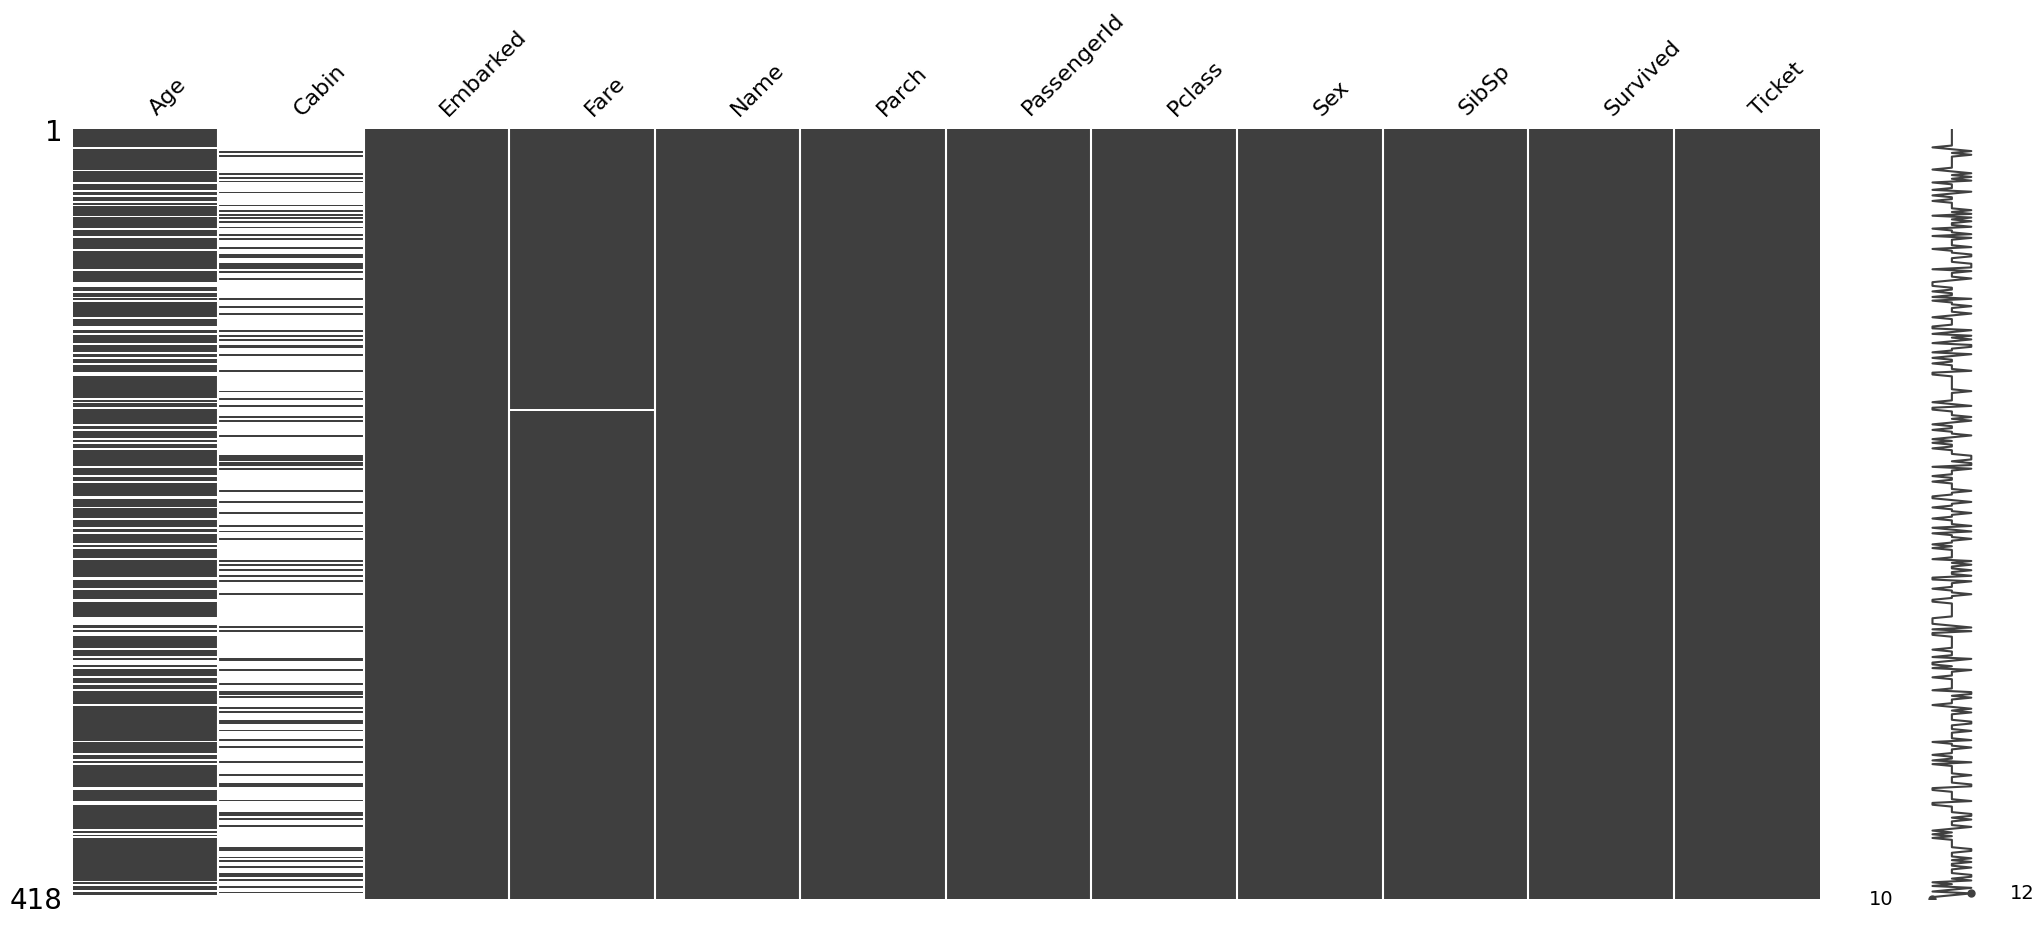

In [537]:
total = df.isnull().sum().sort_values(ascending=False)
print(total.head(5))
# For visualization we will use missing
msno.matrix(test_df)

In [538]:
# understand your dataset 
df.columns.values
# What features can affect the survival rate? NOT passengerID, Name or Ticket. 

array(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket'], dtype=object)

In our training dataset, there are 466 women, 385 survived which is 82.62%
In our training dataset, there are 843 men, 109 survived which is  12.93%


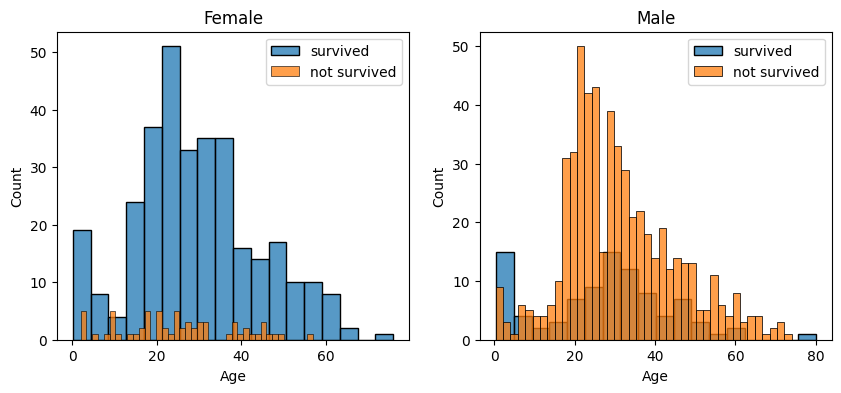

In [539]:
# age and sex

survived = 'survived'
not_survived = 'not survived'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
women = df[df['Sex'] == 'female']
men = df[df['Sex'] == 'male']

women_survived = women[women['Survived'] == 1]
women_not_survived = women[women['Survived'] == 0]
men_survived = men[men['Survived'] == 1]
men_not_survived = men[men['Survived'] == 0]

print(f"In our training dataset, there are {len(women)} women, {len(women_survived)} survived which is {len(women_survived)/len(women) * 100:.2f}%")
print(f"In our training dataset, there are {len(men)} men, {len(men_survived)} survived which is  {len(men_survived)/len(men) *100:.2f}%")

sns.histplot(data=women[women['Survived'] == 1], x='Age', bins=18, label=survived, ax=axes[0], kde=False)
sns.histplot(data=women[women['Survived'] == 0], x='Age', bins=40, label=not_survived, ax=axes[0], kde=False)

axes[0].legend()
axes[0].set_title('Female')

sns.histplot(data=men[men['Survived'] == 1], x='Age', bins=18, label=survived, ax=axes[1], kde=False)
sns.histplot(data=men[men['Survived'] == 0], x='Age', bins=40, label=not_survived, ax=axes[1], kde=False)

axes[1].legend()
_ = axes[1].set_title('Male')

plt.show()


In analyzing the Titanic dataset, it's observed that male passengers aged between 18 and 30 years have a higher survival rate. Women, on the other hand, has increased survival probabilities in the age range of 14 to 40 years.

When examining younger demographics, males aged 5 to 18 have a reduced chance of survival. Infants across both genders have a elevated chance of survival compared to other age groups.

[1, 2, 3]
['female', 'male']


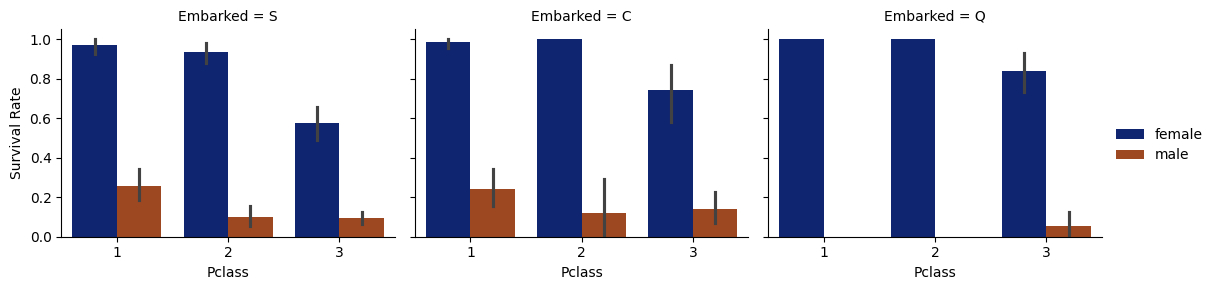

In [540]:

pclass_order = sorted(df['Pclass'].unique())
print(pclass_order)
sex_order = sorted(df['Sex'].unique())
print(sex_order)
FacetGrid = sns.FacetGrid(df, col='Embarked', aspect=1.25)

FacetGrid.map(sns.barplot, 'Pclass', 'Survived', 'Sex', palette='dark', order=pclass_order, hue_order=sex_order)

FacetGrid.add_legend()
FacetGrid.set_axis_labels("Pclass", "Survival Rate")


     - Does class has anything to do with your survival? 

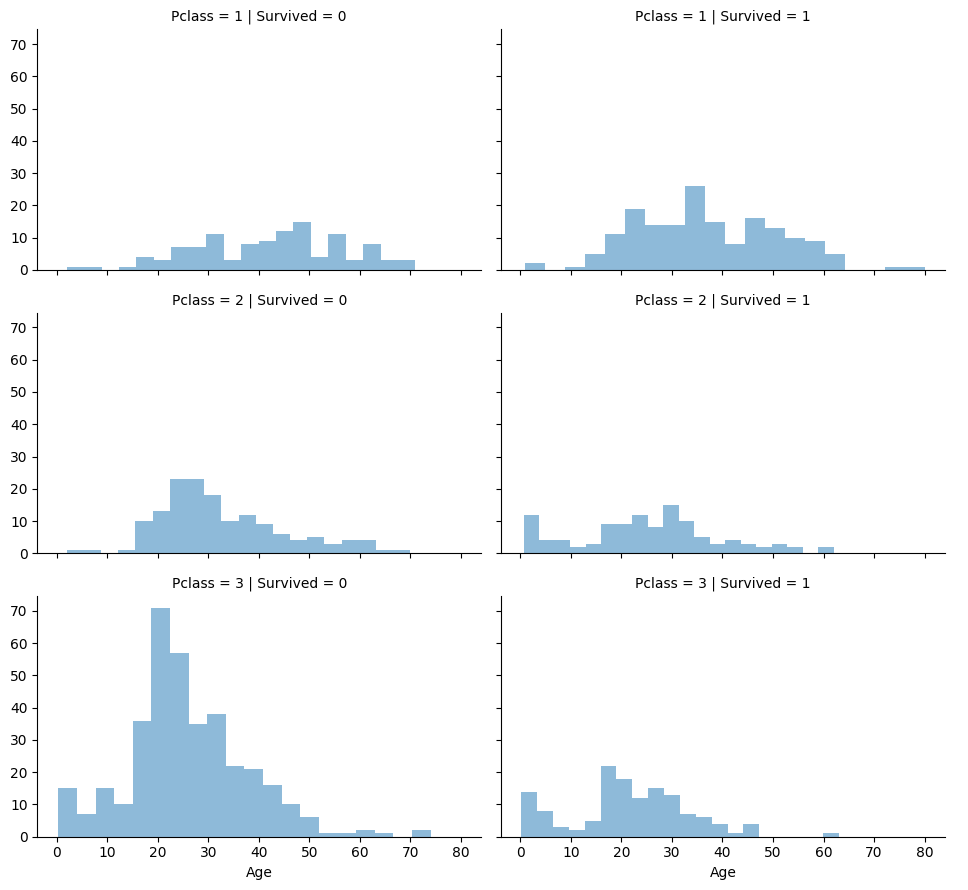

In [541]:
grid = sns.FacetGrid(df, col='Survived', row='Pclass', aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

If you are in class 1 you have a high chance to survive. class 2 chances are likely equal. class 3 low chance to survive.

 
    - Will you survive if you have relatives?

to know if someone is alone or not we need to combine both *SibSp* and *Parch* 

In [542]:
df['Relative'] = df['SibSp'] + df['Parch']
df['Relative'] = df['Relative'].apply(lambda x: 'No Relatives' if x == 0 else 'Relatives')
df.head(10)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Relative
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,Relatives
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1,PC 17599,Relatives
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,No Relatives
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,Relatives
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,No Relatives
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0,330877,No Relatives
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0,17463,No Relatives
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0,349909,Relatives
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1,347742,Relatives
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1,237736,Relatives


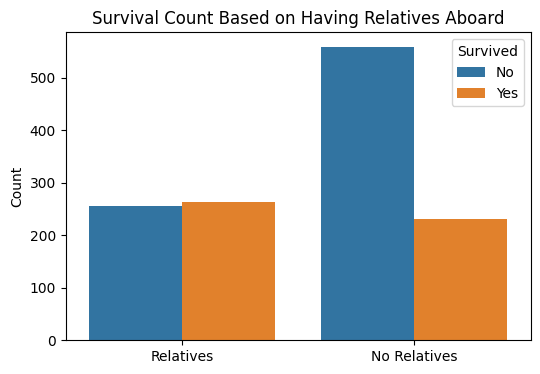

In [543]:
# Now create the bar plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Relative', hue='Survived', data=df)
plt.title('Survival Count Based on Having Relatives Aboard')
plt.ylabel('Count')
plt.xlabel('')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

**Handling Missing Data**

    - Cabin: the first letter is the cabin deck like in C85, the cabin deck is C, lets only keep the cabin deck first letter, if nan then lets call it N


In [544]:
df['Cabin'] = df['Cabin'].fillna('N')
df['Cabin'] = df['Cabin'].apply(lambda x: x[0]) 
print(df['Cabin'].unique())
df['Cabin'].describe()

['N' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


count     1309
unique       9
top          N
freq      1014
Name: Cabin, dtype: object

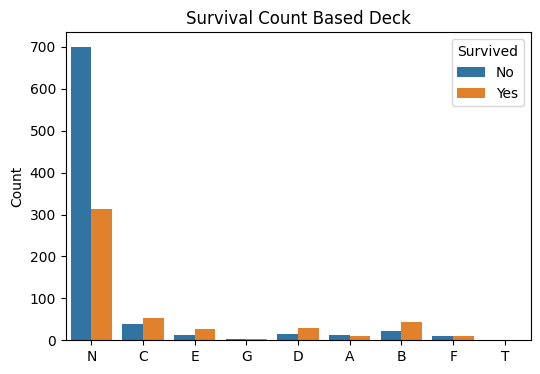

In [545]:
# Now create the bar plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Cabin', hue='Survived', data=df)
plt.title('Survival Count Based Deck')
plt.ylabel('Count')
plt.xlabel('')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

<span style="color:red">I am going to drop Cabin (since it is not very informative) </span>


**Learn the Cut Function**

The cut function in pandas is a tool used to segment and sort data values into bins or categories. This function is particularly useful when you want to categorize a continuous variable into discrete groups, which is a common task in data analysis and feature engineering for machine learning.



In [546]:
import pandas as pd

# Creating a sample DataFrame
dataFrame = pd.DataFrame({'Value': [1, 7, 15, 20, 25, 30, 1, 12]})

# Using cut to bin the data
dataFrame['Category'] = pd.cut(dataFrame['Value'], bins=[0, 10, 20, 30], labels=["Low", "Medium", "High"])

print(dataFrame)


   Value Category
0      1      Low
1      7      Low
2     15   Medium
3     20   Medium
4     25     High
5     30     High
6      1      Low
7     12   Medium


**Overfitting Reduction:** Grouping can help reduce overfitting by generalizing the data. Instead of learning from noise or minor fluctuations in the data, the model learns from more significant, grouped data points.

**Age Filling Missing Data and Grouping:**

    - Filling Missing Data is a common technique known as imputation in Machine Learning.

In [547]:
# fill with the mean (get mean of those who didn't survive and those who survived)
age_survived_mean = df[df['Survived'] == 1]['Age'].dropna().mean()
age_not_survived_mean = df[df['Survived'] == 0]['Age'].dropna().mean()

print(f"Avg age of survival is {age_survived_mean:.0f}, and {age_not_survived_mean:.0f} for those who didn't survived")

# fill empty records 

df.loc[df['Survived'] == 1, 'Age'] = df[df['Survived'] == 1]['Age'].fillna(int(age_survived_mean))
df.loc[df['Survived'] == 0, 'Age'] = df[df['Survived'] == 0]['Age'].fillna(int(age_not_survived_mean))


Avg age of survival is 29, and 31 for those who didn't survived


In [548]:
# lets now add a new feature call it age group and create five classes for age ("Children", "Teen", "Young Adult", "Adult", "Senior"])
  
# Using cut to bin the data
df['AgeGroup'] = pd.cut(df['Age'], 
                         bins=[0, 13, 20, 30, 60, 100], 
                         labels=["Children", "Teen", "Young Adult", "Adult", "Senior"],
                         right=False)

# if right=False:
#   An age of 0-12 would be categorized as "Children".
#   An age of 13 would fall into the next category, "Teen", and not "Children".

df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Relative,AgeGroup
0,22.0,N,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,Relatives,Young Adult
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1,PC 17599,Relatives,Adult
2,26.0,N,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,No Relatives,Young Adult
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,Relatives,Adult
4,35.0,N,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,No Relatives,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,30.0,N,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,0,A.5. 3236,No Relatives,Adult
1305,39.0,C,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,1,PC 17758,No Relatives,Adult
1306,38.5,N,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,0,SOTON/O.Q. 3101262,No Relatives,Adult
1307,30.0,N,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,0,359309,No Relatives,Adult


**Title**

In the Titanic dataset, titles extracted from passenger names can provide additional insights into the passengers' demographics, such as their social status, age, and sex, which can be crucial for data analysis or predictive modeling.

    -- We can extract and understand the tiltes then convert later

In [549]:
df['Name'].head(10)

0                                Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Thayer)
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [550]:

df ['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False) 
df ['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

<span style="font-family: Arial; font-size: 14px;">Zheng, A., &amp; Casari, A. (2018). <em>Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists</em>. O'Reilly Media.</span>


In [551]:
titles = {
    "Mr": 1, 
    "Miss": 2, 
    "Mrs": 3, 
    "Master": 4, 
    "Don": 5, # Spanish for Sir
    "Rev": 5, # Reverend Clergy
    "Dr": 5, 
    "Mme": 3,  # Madame, equivalent to Mrs
    "Ms": 2,   # Ms can be considered equivalent to Miss
    "Major": 5, 
    "Lady": 5, 
    "Sir": 5, 
    "Mlle": 2, # Mademoiselle, equivalent to Miss
    "Col": 5, 
    "Capt": 5, 
    "Countess": 5, 
    "Jonkheer": 5, 
    "Dona": 5   # Dona, equivalent to Lady or Countess
}


**Embarked:**

Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.

In [552]:
df['Embarked'] = df['Embarked'].fillna('S')
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

**Fare:**

The is one missing value for fare (I will just do either filla or fillb)

In [553]:
missing_value = df[df['Fare'].isnull()]
missing_value

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Relative,AgeGroup,Title
1043,60.5,N,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,0,3701,No Relatives,Senior,Mr


In [554]:
df['Fare'] = df['Fare'].ffill()

**Convert Data and Final Walk**

In [555]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Age          1309 non-null   float64 
 1   Cabin        1309 non-null   object  
 2   Embarked     1309 non-null   object  
 3   Fare         1309 non-null   float64 
 4   Name         1309 non-null   object  
 5   Parch        1309 non-null   int64   
 6   PassengerId  1309 non-null   int64   
 7   Pclass       1309 non-null   int64   
 8   Sex          1309 non-null   object  
 9   SibSp        1309 non-null   int64   
 10  Survived     1309 non-null   int64   
 11  Ticket       1309 non-null   object  
 12  Relative     1309 non-null   object  
 13  AgeGroup     1309 non-null   category
 14  Title        1309 non-null   object  
dtypes: category(1), float64(2), int64(5), object(7)
memory usage: 154.9+ KB


In [556]:
df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Relative,AgeGroup,Title
0,22.0,N,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,Relatives,Young Adult,Mr
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1,PC 17599,Relatives,Adult,Mrs
2,26.0,N,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,No Relatives,Young Adult,Miss
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,Relatives,Adult,Mrs
4,35.0,N,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,No Relatives,Adult,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,30.0,N,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,0,A.5. 3236,No Relatives,Adult,Mr
1305,39.0,C,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,1,PC 17758,No Relatives,Adult,Dona
1306,38.5,N,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,0,SOTON/O.Q. 3101262,No Relatives,Adult,Mr
1307,30.0,N,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,0,359309,No Relatives,Adult,Mr


In [557]:
# dop cabin
df = df.drop(['Cabin'], axis=1)

# drop name 
df = df.drop(['Name'], axis=1)

# drop name 
df = df.drop(['Ticket'], axis=1)

# drop name 
df = df.drop(['PassengerId'], axis=1)

# drop age becuase we are using age_group
df = df.drop(['Age'], axis=1)



In [558]:
# convert sex to male --> 0 Female --> 1
genders = {"male": 0, "female": 1}
df['Sex'] = df['Sex'].map(genders)

# convert relatives
relatives = {"Relatives": 1, "No Relatives": 0}
df['Relative'] = df['Relative'].map(relatives)

# convert age group 
age_group = {"Children": 0, "Teen": 1, "Young Adult": 2, "Adult": 3, "Senior": 4}
df['AgeGroup'] = df['AgeGroup'].map(age_group)

# convert Embarked
embarked = {"S":0, "C":1, "Q": 2 }
df['Embarked'] = df['Embarked'].map(embarked)

# convert fare to int 
df['Fare'] = df['Fare'].astype(int)

# convert Title
# 5 is not common today 
titles = {
    "Mr": 1, 
    "Miss": 2, 
    "Mrs": 3, 
    "Master": 4, 
    "Don": 5, # Spanish for Sir
    "Rev": 5, # Reverend Clergy
    "Dr": 5, 
    "Mme": 3,  # Madame, equivalent to Mrs
    "Ms": 2,   # Ms can be considered equivalent to Miss
    "Major": 5, 
    "Lady": 5, 
    "Sir": 5, 
    "Mlle": 2, # Mademoiselle, equivalent to Miss
    "Col": 5, 
    "Capt": 5, 
    "Countess": 5, 
    "Jonkheer": 5, 
    "Dona": 5   # Dona, equivalent to Lady or Countess
}
df['Title'] = df['Title'].map(titles)


In [559]:
df.head(10)

,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Relative,AgeGroup,Title
0,0,7,0,3,0,1,0,1,2,1
1,1,71,0,1,1,1,1,1,3,3
2,0,7,0,3,1,0,1,0,2,2
3,0,53,0,1,1,1,1,1,3,3
4,0,8,0,3,0,0,0,0,3,1
5,2,8,0,3,0,0,0,0,3,1
6,0,51,0,1,0,0,0,0,3,1
7,0,21,1,3,0,3,0,1,0,4
8,0,11,2,3,1,0,1,1,2,3
9,1,30,0,2,1,1,1,1,1,3


**Do we need to normalize Fare?** 
 Some algorithms are sensitive to the scale of the data. For instance, gradient descent-based algorithms converge faster when the features are on a similar scale. Distance-based algorithms like k-Nearest Neighbors (k-NN) or k-Means are also affected by the scale of the data.

 **Two Famouse Methods**


-- Min-Max Normalization: 

$X^{\prime}=\frac{X-X \min }{X \max -X \min }$

Z-score Normalization (Standardization):

$Z=\frac{X-\mu}{\sigma}$

**Let's use Min-Max** This rescales the feature to a fixed range, usually 0 to 1.
 

In [560]:
df['Fare'] = (df['Fare'] - df['Fare'].min()) / (df['Fare'].max() - df['Fare'].min())


In [561]:
df.head(10)

,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Relative,AgeGroup,Title
0,0,0.013672,0,3,0,1,0,1,2,1
1,1,0.138672,0,1,1,1,1,1,3,3
2,0,0.013672,0,3,1,0,1,0,2,2
3,0,0.103516,0,1,1,1,1,1,3,3
4,0,0.015625,0,3,0,0,0,0,3,1
5,2,0.015625,0,3,0,0,0,0,3,1
6,0,0.099609,0,1,0,0,0,0,3,1
7,0,0.041016,1,3,0,3,0,1,0,4
8,0,0.021484,2,3,1,0,1,1,2,3
9,1,0.058594,0,2,1,1,1,1,1,3


**Now the Dataset is ready for training**